# Classification of Localizer Data

## Import necessary packages

In [6]:
%matplotlib inline

In [7]:
import glob
import os.path as op
import os as os
import nibabel as nib
import pandas as pd
import numpy as np

from nilearn.masking import compute_epi_mask

import matplotlib.pyplot as plt
import matplotlib as mpl

# Nilearn for neuro-imaging-specific machine learning
from nilearn.input_data import NiftiMasker
from nilearn import image

# Nibabel for general neuro-imaging tools
import nibabel

# Scikit-learn for machine learning
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import LeaveOneLabelOut, LeavePLabelOut, cross_val_score
from sklearn import preprocessing

# Plotting
import matplotlib.pyplot as plt
from nilearn import plotting
import seaborn as sns
sns.set(context="poster", style="ticks", font="Arial")


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j], decimals=2),
                 horizontalalignment="center", size='xx-large',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def plot_results(subj_info, cm_group, df_acc, df_auc=None, 
                 classes=['animal', 'face', 'fruitveg', 'tool', 'virtualtown']):
    
    if df_auc is not None:
        data = df_auc.merge(subj_info)
        print data.group.value_counts()/10
    
    plt.figure()
    plot_confusion_matrix(cm_group.mean(axis=0), classes=classes,
                          title='Mean confusion matrix')
    
    plt.figure()
    sns.factorplot(x='category', y='accuracy', hue='classifier', aspect=2,
                   units='subid', ci=68, data=df_acc, dodge=.1)
    
    plt.figure()
    sns.boxplot(x='category', y='accuracy', hue='classifier', data=df_acc)
    sns.stripplot(x='category', y='accuracy', hue='classifier', jitter=True, 
                  data=df_acc)
    
    if df_auc is not None:
        sns.factorplot(x='category', y='auc', hue='group', aspect=2,
                       units='subid', ci=68, data=data, dodge=.1)

#### Set up some colors for the plots

In [8]:
palette = {'logreg': 'mediumseagreen',
           'chance': 'darkgray',
           'f1 score': 'teal'}

### Define some functions for classification

In [9]:
# While debugging:
%load_ext autoreload
%aimport ap_classify

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from ap_classify import *

## Set up directory & file information

In [11]:
smoothing = 'unsmoothed'
regspace = 'epi'
design = 'localizer_cond_mvpa.csv' # onset file in lyman-style
# design = 'localizer_subcat.csv' # onset file in lyman-style
smoothing_fwhm = 0
standardize = True
tr = float(2) # in seconds
tr_shift = 4.5 # seconds to shift forward by
ts_type = 'raw' # raw or residual
run_list = [7, 8]

basedir = '/Volumes/group/awagner/sgagnon/AP'
analydir = op.join(basedir, 'analysis/mvpa_raw')
subjfile = op.join(analydir, 'notebooks/subj_info.csv')
subj_info = pd.read_csv(subjfile)

# Filepath templates
if ts_type == 'raw':
    tsfilename = 'timeseries_xfm.nii.gz'
elif ts_type == 'residual':
    tsfilename = 'res4d_xfm.nii.gz'
tsfile = op.join(analydir, "{subid}", 'reg', regspace, 
                 smoothing, "run_{run_id}", tsfilename)
func_maskfile = op.join(analydir, "{subid}", 'reg', regspace, 
                        smoothing, "run_{run_id}", 'functional_mask_xfm.nii.gz')
maskfile = op.join(basedir, 'data', "{subid}", 'masks', 
                   "{mask_name}.nii.gz")
meanfile = op.join(analydir, "{subid}", 'preproc',
                   "run_{run_id}", 'mean_func.nii.gz')
onsetfile = op.join(basedir, 'data', "{subid}", 'design', design)

# Output templates
outnifti = op.join(analydir, "{subid}", 'importance_maps')

artifacts = op.join(analydir, '{subid}', 'preproc', 'run_{run}', 'artifacts.csv')

# Combine paths into dictionary (facilitate passing i/o of funcs)
paths = dict(tsfile=tsfile, func_maskfile=func_maskfile, 
             maskfile=maskfile, meanfile=meanfile, 
             onsetfile=onsetfile, outnifti=outnifti, 
             analydir=analydir, artifacts=artifacts)

We create anatomical masks in native space from a cortical parcellation of the high-resolution T1
image obtained for each participant using FreeSurfer and the resulting **bilateral
inferior temporal cortex**, **fusiform gyrus**, and **parahippocampal gyrus** were combined to serve
as the mask for MVPA classification (as in Zeithamova et al., 2012; *Neuron*).

## Run Classification (training/testing on 3 categories)

In [13]:
subj_info.group.value_counts()

stress     22
control    22
Name: group, dtype: int64

### Run localizer CV:

ap100
Number of voxels: 12
Loading data from run 7 ...
Removing 6 TRs with artifacts...
scaling the data...
# Events: (87,)
Orig TRs: 159
X shape: (87, 12)
Loading data from run 8 ...
Removing 5 TRs with artifacts...
scaling the data...
# Events: (175,)
Orig TRs: 159
X shape: (175, 12)


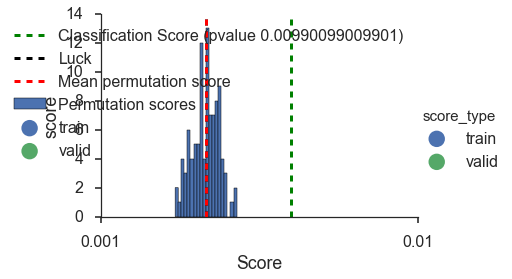

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[36 20  7]
 [19 33  4]
 [ 6  6 44]]
Confusion matrix (normalized):
[[ 0.57142857  0.31746032  0.11111111]
 [ 0.33928571  0.58928571  0.07142857]
 [ 0.10714286  0.10714286  0.78571429]]
ap101
Number of voxels: 17
Loading data from run 7 ...
Removing 2 TRs with artifacts...
scaling the data...
# Events: (91,)
Orig TRs: 159
X shape: (91, 17)
Loading data from run 8 ...
scaling the data...
# Events: (184,)
Orig TRs: 159
X shape: (184, 17)


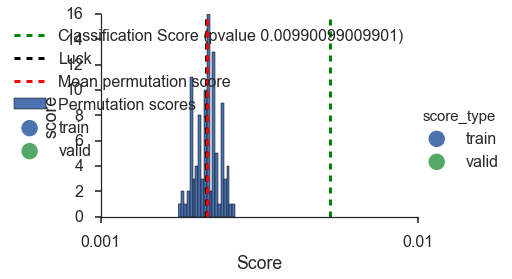

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[40 19  4]
 [20 36  5]
 [ 4  4 52]]
Confusion matrix (normalized):
[[ 0.63492063  0.3015873   0.06349206]
 [ 0.32786885  0.59016393  0.08196721]
 [ 0.06666667  0.06666667  0.86666667]]
ap102
Number of voxels: 25
Loading data from run 7 ...
Removing 5 TRs with artifacts...
scaling the data...
# Events: (88,)
Orig TRs: 159
X shape: (88, 25)
Loading data from run 8 ...
scaling the data...
# Events: (181,)
Orig TRs: 159
X shape: (181, 25)


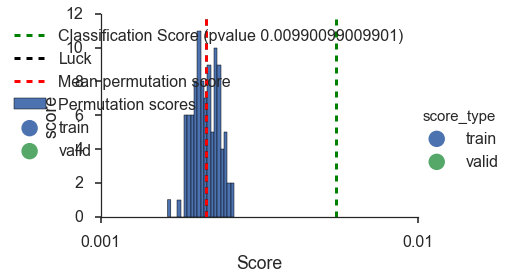

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[51 10  2]
 [23 31  5]
 [ 2  3 54]]
Confusion matrix (normalized):
[[ 0.80952381  0.15873016  0.03174603]
 [ 0.38983051  0.52542373  0.08474576]
 [ 0.03389831  0.05084746  0.91525424]]
ap103
Number of voxels: 17
Loading data from run 7 ...
Removing 1 TRs with artifacts...
scaling the data...
# Events: (92,)
Orig TRs: 159
X shape: (92, 17)
Loading data from run 8 ...
Removing 1 TRs with artifacts...
scaling the data...
# Events: (184,)
Orig TRs: 159
X shape: (184, 17)


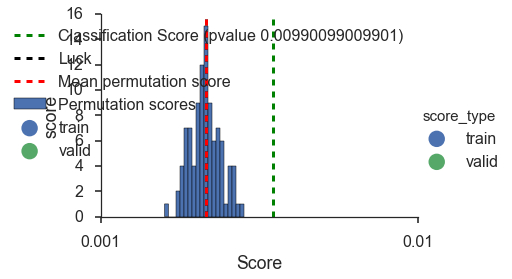

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[40  8 12]
 [17 25 21]
 [ 8 16 37]]
Confusion matrix (normalized):
[[ 0.66666667  0.13333333  0.2       ]
 [ 0.26984127  0.3968254   0.33333333]
 [ 0.13114754  0.26229508  0.60655738]]
ap104
Number of voxels: 19
Loading data from run 7 ...
Removing 4 TRs with artifacts...
scaling the data...
# Events: (89,)
Orig TRs: 159
X shape: (89, 19)
Loading data from run 8 ...
scaling the data...
# Events: (182,)
Orig TRs: 159
X shape: (182, 19)


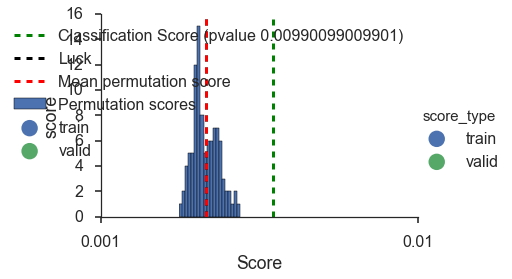

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[39 21  1]
 [29 19 15]
 [ 4 10 44]]
Confusion matrix (normalized):
[[ 0.63934426  0.3442623   0.01639344]
 [ 0.46031746  0.3015873   0.23809524]
 [ 0.06896552  0.17241379  0.75862069]]
ap105
Number of voxels: 17
Loading data from run 7 ...
Removing 1 TRs with artifacts...
scaling the data...
# Events: (92,)
Orig TRs: 159
X shape: (92, 17)
Loading data from run 8 ...
scaling the data...
# Events: (185,)
Orig TRs: 159
X shape: (185, 17)


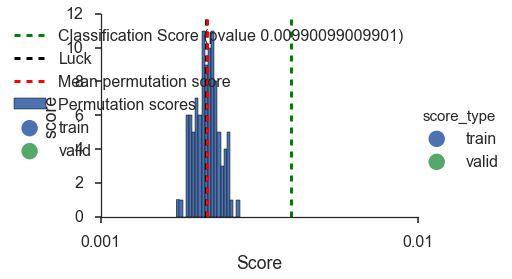

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[36 18  8]
 [16 35 11]
 [12  7 42]]
Confusion matrix (normalized):
[[ 0.58064516  0.29032258  0.12903226]
 [ 0.25806452  0.56451613  0.17741935]
 [ 0.19672131  0.1147541   0.68852459]]
ap107
Number of voxels: 16
Loading data from run 7 ...
Removing 6 TRs with artifacts...
scaling the data...
# Events: (87,)
Orig TRs: 159
X shape: (87, 16)
Loading data from run 8 ...
Removing 4 TRs with artifacts...
scaling the data...
# Events: (176,)
Orig TRs: 159
X shape: (176, 16)


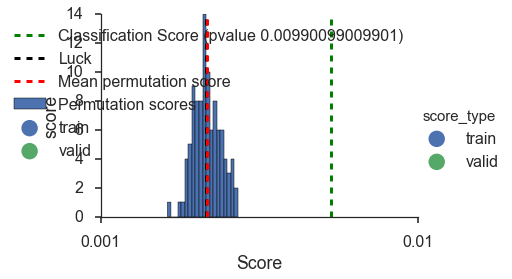

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[51 11  1]
 [15 31 11]
 [ 1  8 47]]
Confusion matrix (normalized):
[[ 0.80952381  0.17460317  0.01587302]
 [ 0.26315789  0.54385965  0.19298246]
 [ 0.01785714  0.14285714  0.83928571]]
ap108
Number of voxels: 17
Loading data from run 7 ...
Removing 2 TRs with artifacts...
scaling the data...
# Events: (91,)
Orig TRs: 159
X shape: (91, 17)
Loading data from run 8 ...
scaling the data...
# Events: (184,)
Orig TRs: 159
X shape: (184, 17)


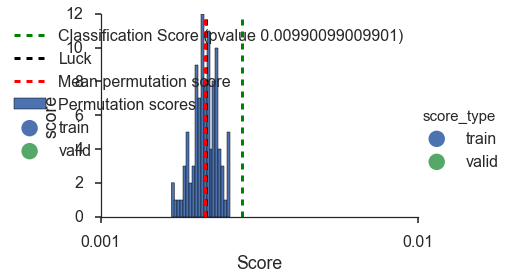

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[39 21  4]
 [28 21 11]
 [12 26 22]]
Confusion matrix (normalized):
[[ 0.609375    0.328125    0.0625    ]
 [ 0.46666667  0.35        0.18333333]
 [ 0.2         0.43333333  0.36666667]]
ap109
Number of voxels: 20
Loading data from run 7 ...
Removing 1 TRs with artifacts...
scaling the data...
# Events: (92,)
Orig TRs: 159
X shape: (92, 20)
Loading data from run 8 ...
Removing 1 TRs with artifacts...
scaling the data...
# Events: (184,)
Orig TRs: 159
X shape: (184, 20)


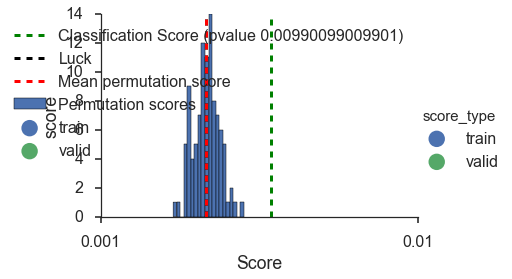

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[25 17 19]
 [14 35 11]
 [10 13 40]]
Confusion matrix (normalized):
[[ 0.40983607  0.27868852  0.31147541]
 [ 0.23333333  0.58333333  0.18333333]
 [ 0.15873016  0.20634921  0.63492063]]
ap110
Number of voxels: 15
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 15)
Loading data from run 8 ...
Removing 0 TRs with artifacts...
scaling the data...
# Events: (186,)
Orig TRs: 159
X shape: (186, 15)


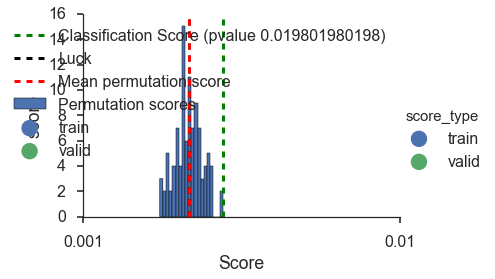

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[27 24 12]
 [26 16 20]
 [12 10 39]]
Confusion matrix (normalized):
[[ 0.42857143  0.38095238  0.19047619]
 [ 0.41935484  0.25806452  0.32258065]
 [ 0.19672131  0.16393443  0.63934426]]
ap111
Number of voxels: 19
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 19)
Loading data from run 8 ...
scaling the data...
# Events: (186,)
Orig TRs: 159
X shape: (186, 19)


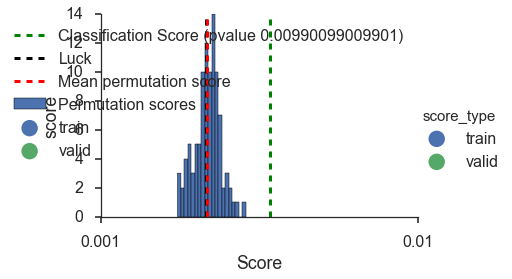

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[27 20 15]
 [13 37 14]
 [10 14 36]]
Confusion matrix (normalized):
[[ 0.43548387  0.32258065  0.24193548]
 [ 0.203125    0.578125    0.21875   ]
 [ 0.16666667  0.23333333  0.6       ]]
ap113
Number of voxels: 22
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 22)
Loading data from run 8 ...
scaling the data...
# Events: (186,)
Orig TRs: 159
X shape: (186, 22)


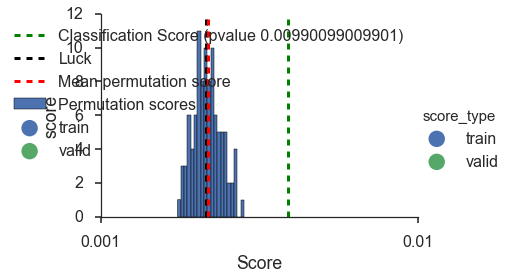

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[45 15  3]
 [20 27 15]
 [ 3 18 40]]
Confusion matrix (normalized):
[[ 0.71428571  0.23809524  0.04761905]
 [ 0.32258065  0.43548387  0.24193548]
 [ 0.04918033  0.29508197  0.6557377 ]]
ap114
Number of voxels: 19
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 19)
Loading data from run 8 ...
scaling the data...
# Events: (186,)
Orig TRs: 159
X shape: (186, 19)


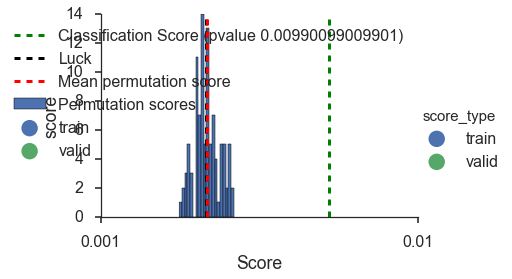

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[47 13  3]
 [12 40  8]
 [ 4 13 46]]
Confusion matrix (normalized):
[[ 0.74603175  0.20634921  0.04761905]
 [ 0.2         0.66666667  0.13333333]
 [ 0.06349206  0.20634921  0.73015873]]
ap115
Number of voxels: 12
Loading data from run 7 ...
Removing 0 TRs with artifacts...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 12)
Loading data from run 8 ...
Removing 1 TRs with artifacts...
scaling the data...
# Events: (185,)
Orig TRs: 159
X shape: (185, 12)


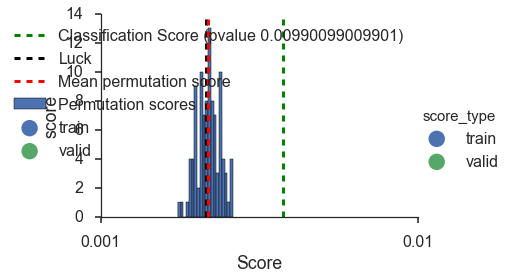

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[45  7 11]
 [12 35 15]
 [12 22 26]]
Confusion matrix (normalized):
[[ 0.71428571  0.11111111  0.17460317]
 [ 0.19354839  0.56451613  0.24193548]
 [ 0.2         0.36666667  0.43333333]]
ap116
Number of voxels: 22
Loading data from run 7 ...
Removing 7 TRs with artifacts...
scaling the data...
# Events: (86,)
Orig TRs: 159
X shape: (86, 22)
Loading data from run 8 ...
scaling the data...
# Events: (179,)
Orig TRs: 159
X shape: (179, 22)


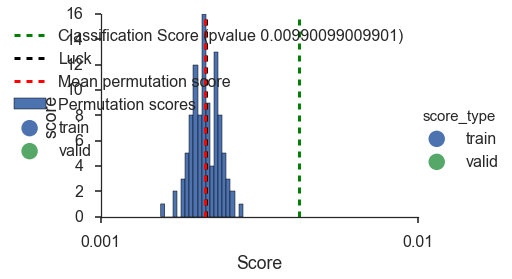

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[40 11  6]
 [15 26 19]
 [ 8 11 43]]
Confusion matrix (normalized):
[[ 0.70175439  0.19298246  0.10526316]
 [ 0.25        0.43333333  0.31666667]
 [ 0.12903226  0.17741935  0.69354839]]
ap117
Number of voxels: 13
Loading data from run 7 ...
Removing 1 TRs with artifacts...
scaling the data...
# Events: (92,)
Orig TRs: 159
X shape: (92, 13)
Loading data from run 8 ...
Removing 4 TRs with artifacts...
scaling the data...
# Events: (181,)
Orig TRs: 159
X shape: (181, 13)


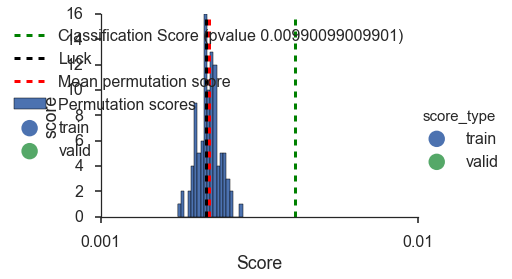

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[46 10  5]
 [16 27 20]
 [ 8 11 38]]
Confusion matrix (normalized):
[[ 0.75409836  0.16393443  0.08196721]
 [ 0.25396825  0.42857143  0.31746032]
 [ 0.14035088  0.19298246  0.66666667]]
ap118
Number of voxels: 15
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 15)
Loading data from run 8 ...
Removing 1 TRs with artifacts...
scaling the data...
# Events: (185,)
Orig TRs: 159
X shape: (185, 15)


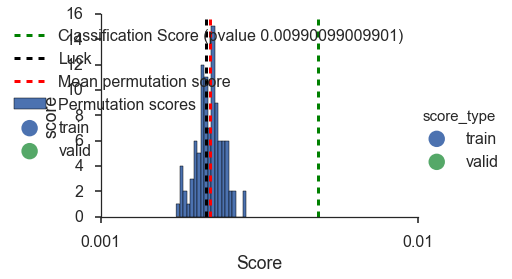

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[42  6 12]
 [ 7 44 11]
 [ 9 12 42]]
Confusion matrix (normalized):
[[ 0.7         0.1         0.2       ]
 [ 0.11290323  0.70967742  0.17741935]
 [ 0.14285714  0.19047619  0.66666667]]
ap119
Number of voxels: 10
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 10)
Loading data from run 8 ...
scaling the data...
# Events: (186,)
Orig TRs: 159
X shape: (186, 10)


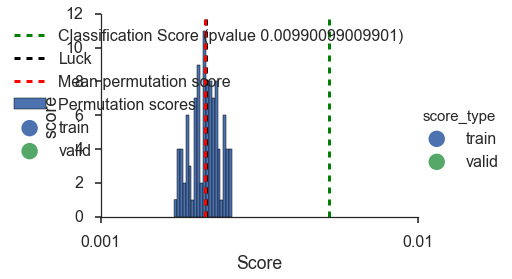

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[57  5  2]
 [12 30 19]
 [ 3 13 45]]
Confusion matrix (normalized):
[[ 0.890625    0.078125    0.03125   ]
 [ 0.19672131  0.49180328  0.31147541]
 [ 0.04918033  0.21311475  0.73770492]]
ap120
Number of voxels: 15
Loading data from run 7 ...
Removing 0 TRs with artifacts...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 15)
Loading data from run 8 ...
Removing 3 TRs with artifacts...
scaling the data...
# Events: (183,)
Orig TRs: 159
X shape: (183, 15)


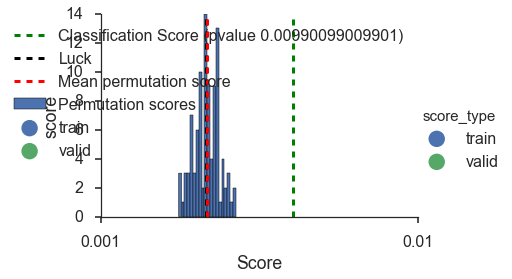

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[36 15  8]
 [22 29 12]
 [ 8  7 46]]
Confusion matrix (normalized):
[[ 0.61016949  0.25423729  0.13559322]
 [ 0.34920635  0.46031746  0.19047619]
 [ 0.13114754  0.1147541   0.75409836]]
ap121
Number of voxels: 20
Loading data from run 7 ...
Removing 1 TRs with artifacts...
scaling the data...
# Events: (92,)
Orig TRs: 159
X shape: (92, 20)
Loading data from run 8 ...
Removing 4 TRs with artifacts...
scaling the data...
# Events: (181,)
Orig TRs: 159
X shape: (181, 20)


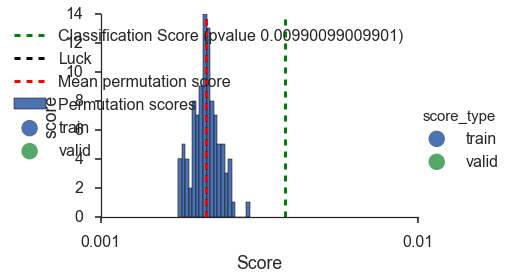

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[41 12  7]
 [11 30 19]
 [13 15 33]]
Confusion matrix (normalized):
[[ 0.68333333  0.2         0.11666667]
 [ 0.18333333  0.5         0.31666667]
 [ 0.21311475  0.24590164  0.54098361]]
ap122
Number of voxels: 15
Loading data from run 7 ...
Removing 6 TRs with artifacts...
scaling the data...
# Events: (87,)
Orig TRs: 159
X shape: (87, 15)
Loading data from run 8 ...
scaling the data...
# Events: (180,)
Orig TRs: 159
X shape: (180, 15)


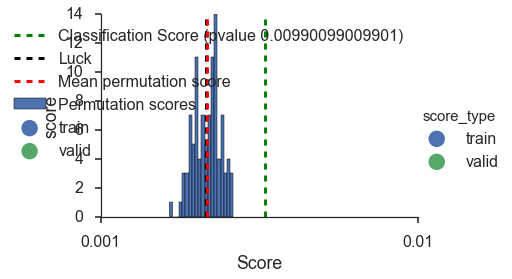

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[23 26 15]
 [22 33  6]
 [ 8 11 36]]
Confusion matrix (normalized):
[[ 0.359375    0.40625     0.234375  ]
 [ 0.36065574  0.54098361  0.09836066]
 [ 0.14545455  0.2         0.65454545]]
ap150
Number of voxels: 19
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 19)
Loading data from run 8 ...
Removing 0 TRs with artifacts...
scaling the data...
# Events: (184,)
Orig TRs: 159
X shape: (184, 19)


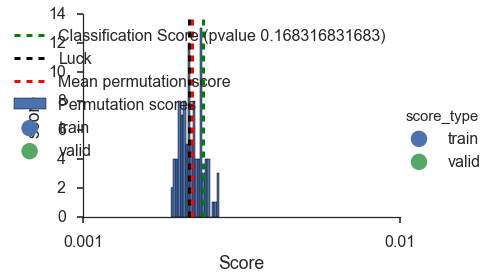

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[25 31  5]
 [23 18 23]
 [ 7 19 33]]
Confusion matrix (normalized):
[[ 0.40983607  0.50819672  0.08196721]
 [ 0.359375    0.28125     0.359375  ]
 [ 0.11864407  0.3220339   0.55932203]]
ap152
Number of voxels: 23
Loading data from run 7 ...
Removing 6 TRs with artifacts...
scaling the data...
# Events: (87,)
Orig TRs: 159
X shape: (87, 23)
Loading data from run 8 ...
Removing 2 TRs with artifacts...
scaling the data...
# Events: (178,)
Orig TRs: 159
X shape: (178, 23)


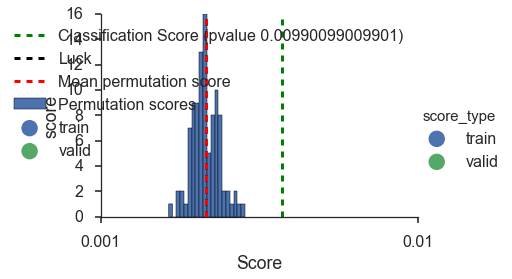

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[36 12 12]
 [20 30 12]
 [ 5 17 34]]
Confusion matrix (normalized):
[[ 0.6         0.2         0.2       ]
 [ 0.32258065  0.48387097  0.19354839]
 [ 0.08928571  0.30357143  0.60714286]]
ap153
Number of voxels: 12
Loading data from run 7 ...
Removing 1 TRs with artifacts...
scaling the data...
# Events: (92,)
Orig TRs: 159
X shape: (92, 12)
Loading data from run 8 ...
Removing 0 TRs with artifacts...
scaling the data...
# Events: (185,)
Orig TRs: 159
X shape: (185, 12)


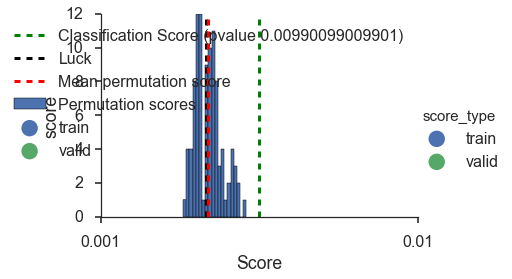

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[23 14 22]
 [15 34 15]
 [12 13 37]]
Confusion matrix (normalized):
[[ 0.38983051  0.23728814  0.37288136]
 [ 0.234375    0.53125     0.234375  ]
 [ 0.19354839  0.20967742  0.59677419]]
ap154
Number of voxels: 19
Loading data from run 7 ...
Removing 1 TRs with artifacts...
scaling the data...
# Events: (92,)
Orig TRs: 159
X shape: (92, 19)
Loading data from run 8 ...
Removing 0 TRs with artifacts...
scaling the data...
# Events: (185,)
Orig TRs: 159
X shape: (185, 19)


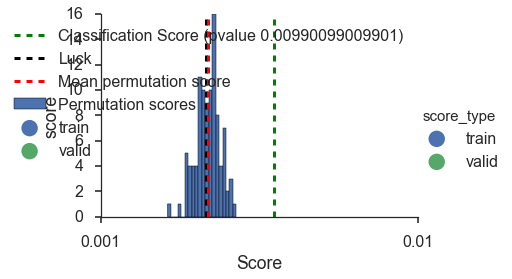

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[44 15  3]
 [30 18 13]
 [ 6 17 39]]
Confusion matrix (normalized):
[[ 0.70967742  0.24193548  0.0483871 ]
 [ 0.49180328  0.29508197  0.21311475]
 [ 0.09677419  0.27419355  0.62903226]]
ap155
Number of voxels: 14
Loading data from run 7 ...
Removing 5 TRs with artifacts...
scaling the data...
# Events: (88,)
Orig TRs: 159
X shape: (88, 14)
Loading data from run 8 ...
Removing 6 TRs with artifacts...
scaling the data...
# Events: (175,)
Orig TRs: 159
X shape: (175, 14)


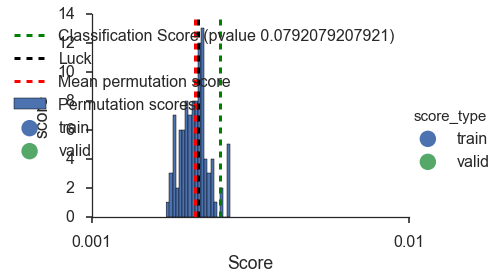

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[19 18 21]
 [12 33 15]
 [22 12 23]]
Confusion matrix (normalized):
[[ 0.32758621  0.31034483  0.36206897]
 [ 0.2         0.55        0.25      ]
 [ 0.38596491  0.21052632  0.40350877]]
ap157
Number of voxels: 18
Loading data from run 7 ...
Removing 5 TRs with artifacts...
scaling the data...
# Events: (88,)
Orig TRs: 159
X shape: (88, 18)
Loading data from run 8 ...
scaling the data...
# Events: (181,)
Orig TRs: 159
X shape: (181, 18)


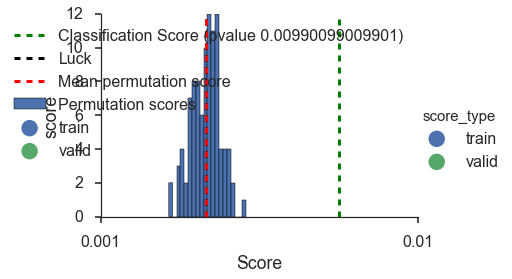

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[46  9  7]
 [ 8 47  7]
 [ 8  4 45]]
Confusion matrix (normalized):
[[ 0.74193548  0.14516129  0.11290323]
 [ 0.12903226  0.75806452  0.11290323]
 [ 0.14035088  0.07017544  0.78947368]]
ap158
Number of voxels: 19
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 19)
Loading data from run 8 ...
scaling the data...
# Events: (186,)
Orig TRs: 159
X shape: (186, 19)


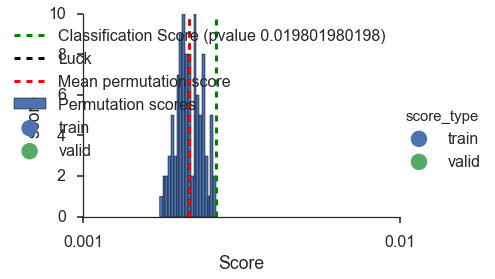

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[23 21 18]
 [23 28 11]
 [21 14 27]]
Confusion matrix (normalized):
[[ 0.37096774  0.33870968  0.29032258]
 [ 0.37096774  0.4516129   0.17741935]
 [ 0.33870968  0.22580645  0.43548387]]
ap159
Number of voxels: 21
Loading data from run 7 ...
Removing 0 TRs with artifacts...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 21)
Loading data from run 8 ...
scaling the data...
# Events: (186,)
Orig TRs: 159
X shape: (186, 21)


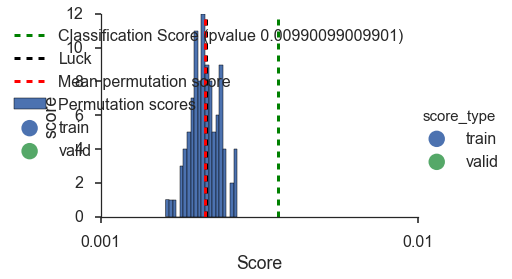

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[24 33  6]
 [17 36  7]
 [13  5 45]]
Confusion matrix (normalized):
[[ 0.38095238  0.52380952  0.0952381 ]
 [ 0.28333333  0.6         0.11666667]
 [ 0.20634921  0.07936508  0.71428571]]
ap160
Number of voxels: 13
Loading data from run 7 ...
Removing 5 TRs with artifacts...
scaling the data...
# Events: (88,)
Orig TRs: 159
X shape: (88, 13)
Loading data from run 8 ...
Removing 1 TRs with artifacts...
scaling the data...
# Events: (180,)
Orig TRs: 159
X shape: (180, 13)


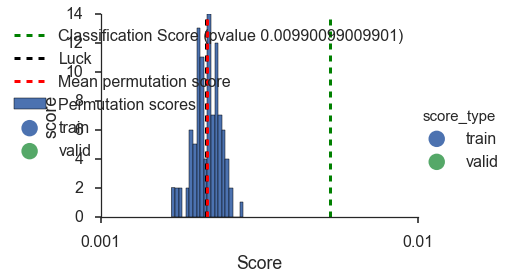

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[38 14  5]
 [19 36  7]
 [ 6  2 53]]
Confusion matrix (normalized):
[[ 0.66666667  0.24561404  0.0877193 ]
 [ 0.30645161  0.58064516  0.11290323]
 [ 0.09836066  0.03278689  0.86885246]]
ap161
Number of voxels: 14
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 14)
Loading data from run 8 ...
Removing 2 TRs with artifacts...
scaling the data...
# Events: (184,)
Orig TRs: 159
X shape: (184, 14)


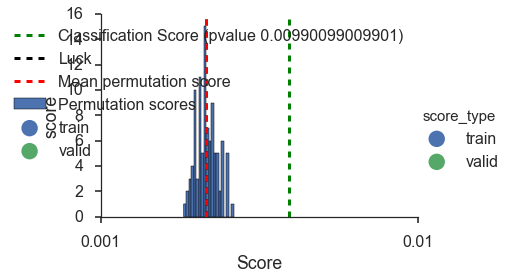

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[32 16 13]
 [20 29 12]
 [ 3 11 48]]
Confusion matrix (normalized):
[[ 0.52459016  0.26229508  0.21311475]
 [ 0.32786885  0.47540984  0.19672131]
 [ 0.0483871   0.17741935  0.77419355]]
ap162
Number of voxels: 17
Loading data from run 7 ...
Removing 4 TRs with artifacts...
scaling the data...
# Events: (89,)
Orig TRs: 159
X shape: (89, 17)
Loading data from run 8 ...
scaling the data...
# Events: (182,)
Orig TRs: 159
X shape: (182, 17)


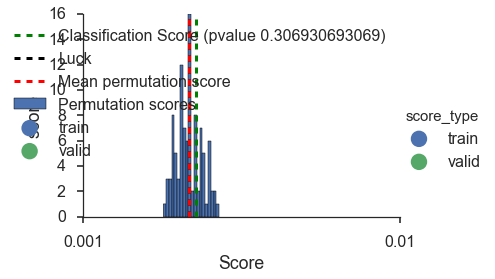

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[15 25 19]
 [24 29 11]
 [20 16 23]]
Confusion matrix (normalized):
[[ 0.25423729  0.42372881  0.3220339 ]
 [ 0.375       0.453125    0.171875  ]
 [ 0.33898305  0.27118644  0.38983051]]
ap163
Number of voxels: 12
Loading data from run 7 ...
Removing 2 TRs with artifacts...
scaling the data...
# Events: (89,)
Orig TRs: 159
X shape: (89, 12)
Loading data from run 8 ...
scaling the data...
# Events: (182,)
Orig TRs: 159
X shape: (182, 12)


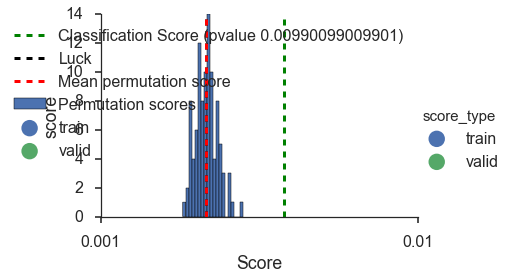

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[29 17 15]
 [24 33  3]
 [12  5 44]]
Confusion matrix (normalized):
[[ 0.47540984  0.27868852  0.24590164]
 [ 0.4         0.55        0.05      ]
 [ 0.19672131  0.08196721  0.72131148]]
ap164
Number of voxels: 23
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 23)
Loading data from run 8 ...
Removing 3 TRs with artifacts...
scaling the data...
# Events: (183,)
Orig TRs: 159
X shape: (183, 23)


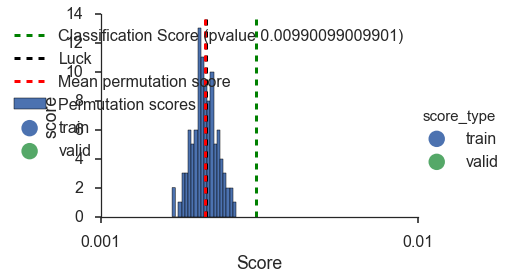

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[24 22 13]
 [19 27 15]
 [ 7 15 41]]
Confusion matrix (normalized):
[[ 0.40677966  0.37288136  0.22033898]
 [ 0.31147541  0.44262295  0.24590164]
 [ 0.11111111  0.23809524  0.65079365]]
ap165
Number of voxels: 19
Loading data from run 7 ...
Removing 3 TRs with artifacts...
scaling the data...
# Events: (90,)
Orig TRs: 159
X shape: (90, 19)
Loading data from run 8 ...
Removing 2 TRs with artifacts...
scaling the data...
# Events: (181,)
Orig TRs: 159
X shape: (181, 19)


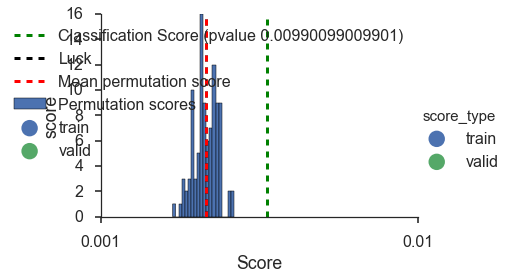

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[35 18 10]
 [13 28 20]
 [ 9 14 34]]
Confusion matrix (normalized):
[[ 0.55555556  0.28571429  0.15873016]
 [ 0.21311475  0.45901639  0.32786885]
 [ 0.15789474  0.24561404  0.59649123]]
ap166
Number of voxels: 13
Loading data from run 7 ...
Removing 0 TRs with artifacts...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 13)
Loading data from run 8 ...
Removing 3 TRs with artifacts...
scaling the data...
# Events: (183,)
Orig TRs: 159
X shape: (183, 13)


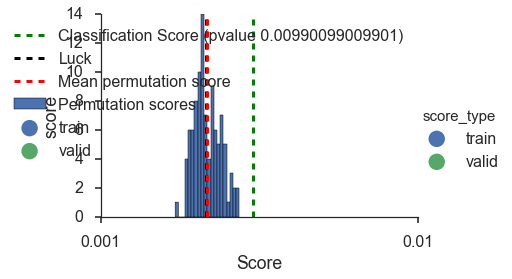

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[34  8 22]
 [17 28 16]
 [13 25 20]]
Confusion matrix (normalized):
[[ 0.53125     0.125       0.34375   ]
 [ 0.27868852  0.45901639  0.26229508]
 [ 0.22413793  0.43103448  0.34482759]]
ap167
Number of voxels: 19
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 19)
Loading data from run 8 ...
Removing 0 TRs with artifacts...
scaling the data...
# Events: (186,)
Orig TRs: 159
X shape: (186, 19)


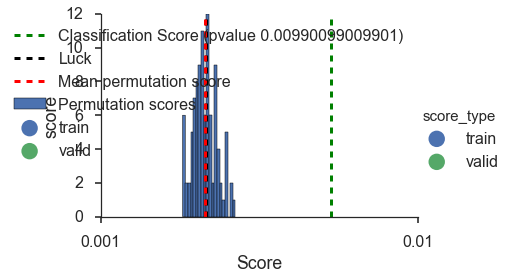

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[51  8  3]
 [20 30 10]
 [ 3  8 53]]
Confusion matrix (normalized):
[[ 0.82258065  0.12903226  0.0483871 ]
 [ 0.33333333  0.5         0.16666667]
 [ 0.046875    0.125       0.828125  ]]
ap168
Number of voxels: 23
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 23)
Loading data from run 8 ...
scaling the data...
# Events: (186,)
Orig TRs: 159
X shape: (186, 23)


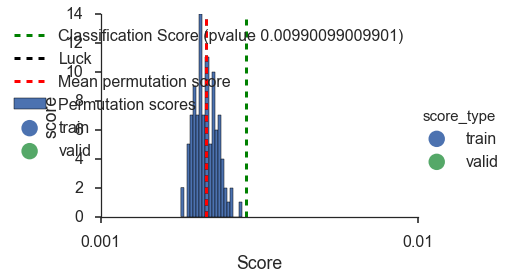

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[28 22 13]
 [19 21 20]
 [11 18 34]]
Confusion matrix (normalized):
[[ 0.44444444  0.34920635  0.20634921]
 [ 0.31666667  0.35        0.33333333]
 [ 0.17460317  0.28571429  0.53968254]]
ap169
Number of voxels: 21
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 21)
Loading data from run 8 ...
Removing 5 TRs with artifacts...
scaling the data...
# Events: (181,)
Orig TRs: 159
X shape: (181, 21)


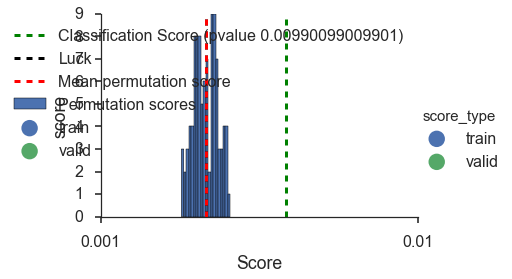

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[35  9 12]
 [19 29 15]
 [ 4 16 42]]
Confusion matrix (normalized):
[[ 0.625       0.16071429  0.21428571]
 [ 0.3015873   0.46031746  0.23809524]
 [ 0.06451613  0.25806452  0.67741935]]
ap170
Number of voxels: 11
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 11)
Loading data from run 8 ...
scaling the data...
# Events: (186,)
Orig TRs: 159
X shape: (186, 11)


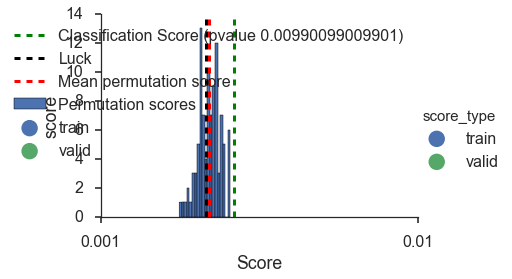

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[25 27 11]
 [26 21 15]
 [16 14 31]]
Confusion matrix (normalized):
[[ 0.3968254   0.42857143  0.17460317]
 [ 0.41935484  0.33870968  0.24193548]
 [ 0.26229508  0.2295082   0.50819672]]
ap171
Number of voxels: 20
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 20)
Loading data from run 8 ...
scaling the data...
# Events: (186,)
Orig TRs: 159
X shape: (186, 20)


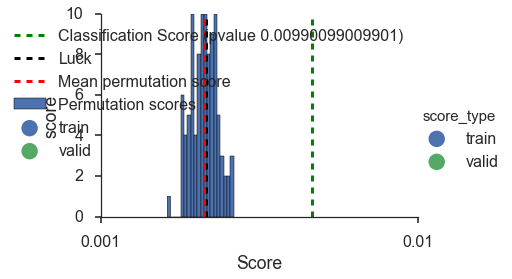

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[44 16  1]
 [17 32 13]
 [ 2 10 51]]
Confusion matrix (normalized):
[[ 0.72131148  0.26229508  0.01639344]
 [ 0.27419355  0.51612903  0.20967742]
 [ 0.03174603  0.15873016  0.80952381]]
ap172
Number of voxels: 14
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 14)
Loading data from run 8 ...
Removing 0 TRs with artifacts...
scaling the data...
# Events: (186,)
Orig TRs: 159
X shape: (186, 14)


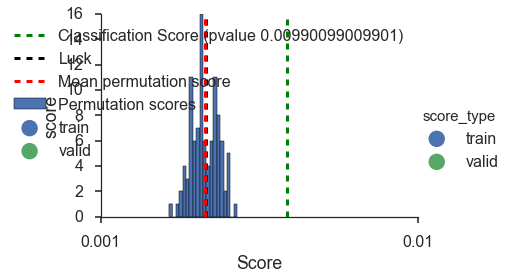

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[22 26 14]
 [13 42  8]
 [ 9  8 44]]
Confusion matrix (normalized):
[[ 0.35483871  0.41935484  0.22580645]
 [ 0.20634921  0.66666667  0.12698413]
 [ 0.14754098  0.13114754  0.72131148]]
ap173
Number of voxels: 24
Loading data from run 7 ...
Removing 1 TRs with artifacts...
scaling the data...
# Events: (92,)
Orig TRs: 159
X shape: (92, 24)
Loading data from run 8 ...
scaling the data...
# Events: (185,)
Orig TRs: 159
X shape: (185, 24)


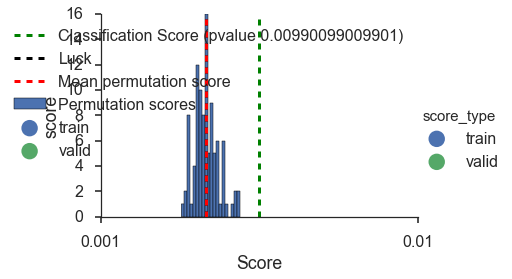

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[35 16  8]
 [23 20 20]
 [10 15 38]]
Confusion matrix (normalized):
[[ 0.59322034  0.27118644  0.13559322]
 [ 0.36507937  0.31746032  0.31746032]
 [ 0.15873016  0.23809524  0.6031746 ]]
ap174
Number of voxels: 15
Loading data from run 7 ...
scaling the data...
# Events: (93,)
Orig TRs: 159
X shape: (93, 15)
Loading data from run 8 ...
Removing 4 TRs with artifacts...
scaling the data...
# Events: (182,)
Orig TRs: 159
X shape: (182, 15)


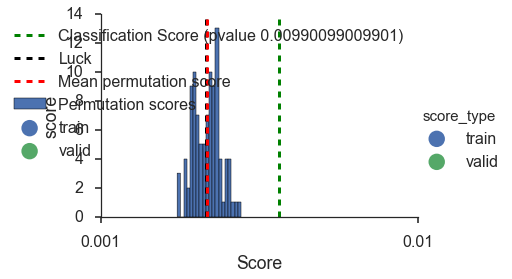

face
object
place
['face' 'object' 'place']
Confusion matrix (raw counts):
[[34 10 19]
 [ 9 41 12]
 [16 16 25]]
Confusion matrix (normalized):
[[ 0.53968254  0.15873016  0.3015873 ]
 [ 0.14516129  0.66129032  0.19354839]
 [ 0.28070175  0.28070175  0.43859649]]


In [226]:
# Initialize some dataframes for storage
df = pd.DataFrame(columns=['subid', 'mask_name', 'category', 'type', 'mean', 'sd'])
df_acc = pd.DataFrame(columns=['subid', 'mask_name', 'category', 'classifier', 'accuracy', 'count'])
df_proba = pd.DataFrame(columns=['subid', 'mask_name', 'true_category', 'guess_category', 'classifier', 'probability'])
df_auc = pd.DataFrame()

n_permutations=100
if n_permutations > 0:
    iter_list = list(np.arange(1, n_permutations + 1))
    iter_list.insert(0, 'subid')
    d_permute = pd.DataFrame(columns=iter_list)

mask_type = 'mask' # functional mask, or anatomical mask defined w/mask_name
mask_name = 'bilat-parahipp_fusi_inftemp_nohipp'
# mask_name = 'bilat-fusi_inftemp_nohipp' # excluding parahipp to see if just that
# mask_name = 'lh-inferiorparietal'
cond_list = ['face', 'object', 'place']
multi_class = 'ovr'
pca_n = None #or None
univariate_fsl_k=None # 1000 #or None

# mask_type = 'func' # functional mask, or anatomical mask defined w/mask_name
# mask_name = 'wholebrain'
# cond_list = ['face', 'object', 'place']

# Confusion matrix
cm_group = np.zeros((1,len(cond_list), len(cond_list)))

# Iterate through subjects
for subid in subj_info.subid:
    print subid
    
    onsetfile = paths['onsetfile']
    # Get subj-specific data
    X, run_labels, ev_labels, ev_trs, ev_onsets, func_masker = get_subj_data(subid, onsetfile, cond_list, paths, mask_type, mask_name,
                                                                             smoothing_fwhm, standardize, tr, tr_shift, run_list, 
                                                                             shift_rest=True, filter_artifacts=True)
    
    cv = LeaveOneLabelOut(run_labels)
    plot_validation_curve(X, ev_labels, cv)
    
    # Classification
    if n_permutations > 0:
        df, d_permute = calc_scores(df, subid, mask_name, X, ev_labels, run_labels, 
                                    n_permutations=n_permutations, d_permute=d_permute, 
                                    plot_permutation=True, multi_class=multi_class)
    else:
        df = calc_scores(df, subid, mask_name, X, ev_labels, run_labels, multi_class=multi_class)
    
    if multi_class == 'MLP':
        df_acc, df_proba, cm_group = calc_acc_proba(df_acc, df_proba, subid, mask_name, X, ev_labels, 
                                                    run_labels, cv,conf_mat=True, multi_class=multi_class, 
                                                    cm_group=cm_group)
    else:
        df_acc, df_proba, df_auc, cm_group = calc_acc_proba(df_acc, df_proba, subid, mask_name, X, ev_labels, 
                                                            run_labels, cv,conf_mat=True, multi_class=multi_class, 
                                                            univariate_fsel_k=univariate_fsl_k, undersampling=True,
                                                            pca_n=pca_n,
                                                            cm_group=cm_group,
                                                            compute_AUC=True, df_auc=df_auc,
                                                            repeated_ttest_fsel=None)
    
#     # Create coef maps by training on all data, save niis and pngs to dir
#     create_coef_maps(subid, X, ev_labels, func_masker, mask_name, paths, calc_A=False)

#### First time running script:

In [63]:
# VTC
df_auc.to_csv('output_ap/localizer_vtcnohipp_auc_filterart_raw_scalewithinrun.csv')
df_acc.to_csv('output_ap/localizer_vtcnohipp_accuracy_filterart_raw_scalewithinrun.csv')
df_proba.to_csv('output_ap/localizer_vtcnohipp_proba_filterart_raw_scalewithinrun.csv')
df.to_csv('output_ap/localizer_vtcnohipp_df_filterart_raw_scalewithinrun.csv')
d_permute.to_csv('output_ap/localizer_vtcnohipp_permute_filterart_raw_scalewithinrun.csv')

In [49]:
# Whole hippocampus
df_auc.to_csv('output_ap/localizer_bilat-hipp_auc_filterart_raw_scalewithinrun.csv')
df_acc.to_csv('output_ap/localizer_bilat-hipp_accuracy_filterart_raw_scalewithinrun.csv')
df_proba.to_csv('output_ap/localizer_bilat-hipp_proba_filterart_raw_scalewithinrun.csv')
df.to_csv('output_ap/localizer_bilat-hipp_df_filterart_raw_scalewithinrun.csv')
d_permute.to_csv('output_ap/localizer_bilat-hipp_permute_filterart_raw_scalewithinrun.csv')

In [90]:
# inf parietal
df_auc.to_csv('output_ap/localizer_inferiorparietal_auc_filterart_raw_scalewithinrun.csv')
df_acc.to_csv('output_ap/localizer_inferiorparietal_accuracy_filterart_raw_scalewithinrun.csv')
df_proba.to_csv('output_ap/localizer_inferiorparietal_proba_filterart_raw_scalewithinrun.csv')
df.to_csv('output_ap/localizer_inferiorparietal_df_filterart_raw_scalewithinrun.csv')
d_permute.to_csv('output_ap/localizer_inferiorparietal_permute_filterart_raw_scalewithinrun.csv')